This notebook showcases the kinematic decomposition that was applied to the Illustris, IllustrisTNG, and BRAHMA subhalos

The methodology is to identify stars as belonging to the bulge versus the disk depending on the ratio of their specific angular moomentum in the z direction ($j_z$) to their maximum specific angular momentum given their binding energy ($j_{circ}$). For stars on circular orbits around the galactic center (as is characteristic of stars in the disk), $j_z \sim j_{circ}$, so $\kappa = j_z/j_{circ} \sim 1$. For stars belonging to the bulge, one would expect random velocities distributed normally about $j_z=0$, and so we perform a cut and identify stas with $\kappa < 0.5$ to be part of the bulge, as done in Du et al. (2020): https://ui.adsabs.harvard.edu/abs/2020ApJ...895..139D/abstract.

In [1]:
import sys
from brahma_analysis import *
from scipy.interpolate import interp1d
sys.path.append('/home/yja6qa/arepo_package/')

import arepo_package
import scipy.interpolate
import h5py
import os
import numpy as np
import plotting # Script with specific plotting preferences
from sklearn.linear_model import LinearRegression
from scipy.interpolate import interp1d
from scipy.signal import savgol_filter

%matplotlib inline
radiative_efficiency=0.2

# Removing linear gradient in gravitaional potential

Since galaxies in our volume exist in environments where neighboring cosmic web filaments/galaxies/galaxy clusters can affect the gravitational potentials of stars in the galaxy, we fit a linear gradient to the stellar gravitational potentials and remove this component so as to consider only the gravitational potential due to the galaxy's own constituent particles. This significantly reduces the number of stars which end up with a calculated $\kappa=j_z/j_circ > 1$, which should not be possible. Though this does not perfectly fix this problem, and one could fit higher-order potential gradients to further correct this, we find that this correction is good enough for our purposes and use the resulting potentials in our decomposition.

Loading in a test subhalo from TNG100 at z=0:

In [2]:
TNGpath='/standard/torrey-group/IllustrisTNG/Runs/L75n1820TNG'
basePath = TNGpath
snap_num=99 # z=0
hdr  = il.groupcat.loadHeader(TNGpath, snap_num)
h = hdr['HubbleParam'] ## load in h from the header
box_size = hdr["BoxSize"]
redshift = hdr['Redshift']

In [3]:
subhalo_id = 50
kpc2km = 3.0857e16 # unit conversion to be used later
Subhaloprops = il.groupcat.loadSubhalos(basePath,snap_num,fields=['SubhaloPos','SubhaloVel','SubhaloHalfmassRad'])
HMR = Subhaloprops['SubhaloHalfmassRad'][subhalo_id]

fields = ['Masses','Coordinates','Velocities','Potential']
Star_Props = il.snapshot.loadSubhalo(basePath, snap_num, id=subhalo_id, partType=4, fields=fields)

Coordinates,Velocities,Potentials = Center_subhalo(Star_Props,Subhaloprops,box_size,redshift,h,subhalo_id=subhalo_id)

Here we select the stars beyond the 95th radial percentile. This serves to cut out the central galactic potential so it doesn't skew our linear gradient fit.

In [4]:
rstars = np.sqrt(Coordinates[:,0]**2 + Coordinates[:,1]**2)
r_out_HMR_mask = rstars > np.percentile(rstars, 95) # stars outside 95th percentile of stellar radius
r_out_HMR = rstars[r_out_HMR_mask]

Now we fit a gradient that's linear in x and y to the potential:

In [5]:
def model(xy, a, b, c):
    x, y = xy
    return a * x + b * y + c
    
x = Coordinates[:,0][r_out_HMR_mask]
y = Coordinates[:,1][r_out_HMR_mask]
Potentials_masked = Potentials[r_out_HMR_mask]

params, covariance = curve_fit(model, (x, y), Potentials_masked)
print("Fitted parameters:", params)

Fitted parameters: [-1.20721655e-15  1.77312492e-14 -1.50607357e+06]


Plotting the uncorrected potentials, we see a clear gradient across the subhalo.

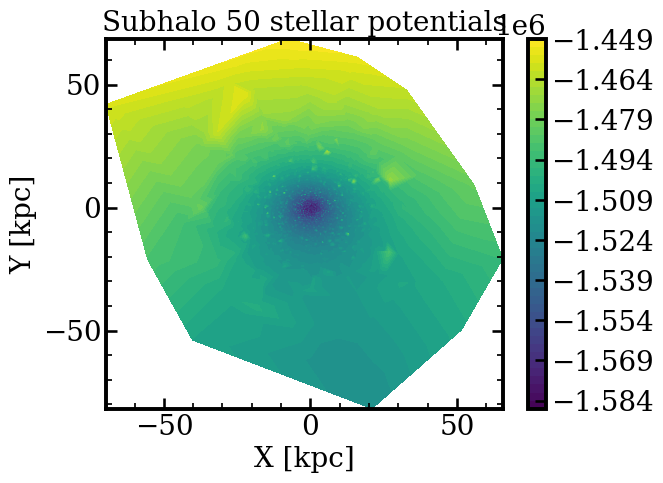

In [6]:
contour=plt.tricontourf(Coordinates[:,0]/kpc2km, Coordinates[:,1]/kpc2km, Potentials, cmap='viridis',levels=50)
plt.colorbar(contour)
plt.xlabel('X [kpc]')
plt.ylabel('Y [kpc]')
plt.title(f'Subhalo {subhalo_id} stellar potentials',size=20)
plt.show()

Now let's plot the linear gradient fit to the potential:

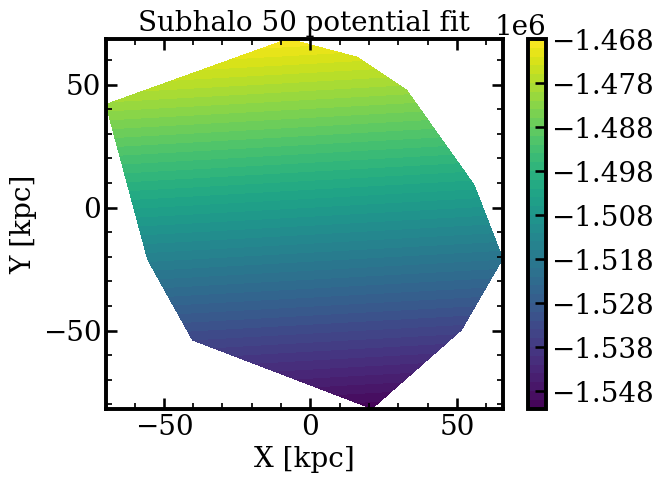

In [7]:
fitted_Z = model((Coordinates[:,0], Coordinates[:,1]), *params)
contour=plt.tricontourf(Coordinates[:,0]/kpc2km, Coordinates[:,1]/kpc2km, fitted_Z, cmap='viridis',levels=50)
plt.colorbar(contour)
plt.xlabel('X [kpc]')
plt.ylabel('Y [kpc]')
plt.title(f'Subhalo {subhalo_id} potential fit',size=20)
plt.show()

And now, the corrected potential:

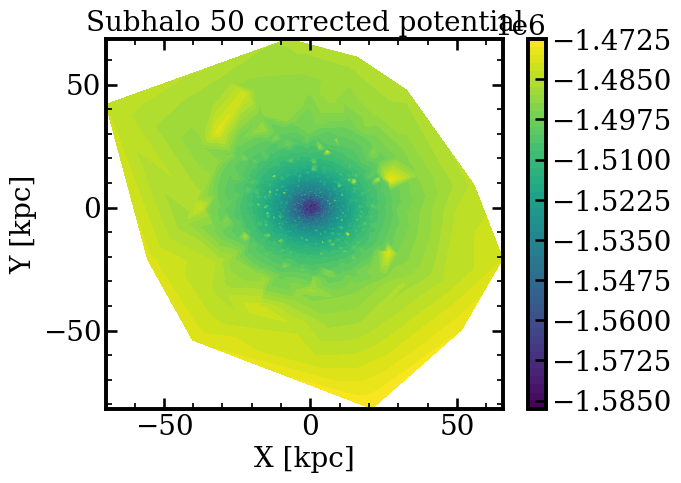

In [8]:
corrected_potential = Potentials - fitted_Z + params[2] # Adding params[2] to keep the normalization
contour=plt.tricontourf(Coordinates[:,0]/kpc2km, Coordinates[:,1]/kpc2km, corrected_potential, cmap='viridis',levels=50)
plt.colorbar(contour)
plt.xlabel('X [kpc]')
plt.ylabel('Y [kpc]')
plt.title(f'Subhalo {subhalo_id} corrected potential',size=20)
plt.show()

While not perfect, this does a reasonably good job at removing the linear dependence of the potential on x and y across the subhalo.

# Applying the kinematic decomposition

Loading in a larger subhalo than above, for a better demonstration of the decomposition

In [9]:
TNGpath='/standard/torrey-group/IllustrisTNG/Runs/L75n1820TNG'
basePath = TNGpath
snap_num=99 # z=0
hdr  = il.groupcat.loadHeader(TNGpath, snap_num)
h = hdr['HubbleParam'] ## load in h from the header
box_size = hdr["BoxSize"]
redshift = hdr['Redshift']

In [10]:
subhalo_id = 12 
kpc2km = 3.0857e16 # unit conversion to be used later
Subhaloprops = il.groupcat.loadSubhalos(basePath,snap_num,fields=['SubhaloPos','SubhaloVel','SubhaloHalfmassRad'])
HMR = Subhaloprops['SubhaloHalfmassRad'][subhalo_id]

fields = ['Masses','Coordinates','Velocities','Potential']
Star_Props = il.snapshot.loadSubhalo(basePath, snap_num, id=subhalo_id, partType=4, fields=fields)

Coordinates,Velocities,Potentials = Center_subhalo(Star_Props,Subhaloprops,box_size,redshift,h,subhalo_id=subhalo_id)

Now applying the kinematic decomposition:

First we create interpolated functions of the potential and potential gradient as a function of radius from the galactic center:

In [11]:
corrected_potential = remove_linear_gradient(Coordinates,Potentials) # Removing linear gradient in potential as done above

r = np.sqrt(Coordinates[:,0]**2 + Coordinates[:,1]**2) # radial distance from subhalo center in the xy plane

height = 3 * kpc2km # kpc for height of disk
ri   = 0 * kpc2km  # from 0
ro   = np.percentile(r, 97.5) # 97.5th percentile of stars

disk_mask = (Coordinates[:,2] > -height) & (Coordinates[:,2] < height)
disk_coords = Coordinates[disk_mask]
disk_pot = corrected_potential[disk_mask]
disk_r = r[disk_mask] 

# Only care about stars within ro
mask = disk_r < ro
rstars_masked = disk_r[mask]
potentials_masked = disk_pot[mask]

# Generating bin centers and averages
bin_centers,bin_averages = equal_num_bins(rstars_masked,potentials_masked)

# Smoothing average values and calculating gradient
window=10
if len(bin_averages) < window: # If less than 10 points, just interpolate based on however many points there are
    potental_interp = interp1d(bin_centers, bin_averages, kind='linear', fill_value="extrapolate")
else:
    smoothed_p = savgol_filter(bin_averages, window_length=window, polyorder=1)
    potental_interp = interp1d(bin_centers, smoothed_p, kind='linear', fill_value="extrapolate")

xvals = np.linspace(0,ro,150)
yvals = np.array([potental_interp(i) for i in xvals])

grad = np.gradient(yvals,xvals)
smoothed_grad= savgol_filter(grad, window_length=window, polyorder=1)
gradient_interp = interp1d(xvals, smoothed_grad, kind='linear', fill_value="extrapolate")

Number of stars per bin: 150


Here we've applied a savgol filter to the radial data before generating the interpolated functions to reduce the noise in the interpolations

Now, we create a function f that we solve for the root of, where f is the sum of the star's actual specific binding energy (KE + PE) minus the specific binding energy the star would have if it were on a circular orbit. For the circular orbit binding energy, we find that from centripetal acceleration, $ v_{circ}^2= r_{circ}\nabla \Phi|_{r_{circ}}$ where $v_{circ}$ is the velocity the star would have if it were on a circular orbit and $r_{circ}$ is the radius the star would be at if it were on a circular orbit, gien its binding energy. The total KE + PE for the star if it were on a circular orbit then is $E = KE + PE = \frac{1}{2}v_{circ}^2 + \Phi = \frac{1}{2}r_{circ}\nabla \Phi|_{r_{circ}} + \Phi$. The root finder allows us to find $r_{circ}$, with which we can calculate $v_{circ}$ from the above relation. This then allows us to calculate $j_{circ} = r_{circ} \times v_{circ}$.

In [12]:
# Defining new function for root finder to calculate rc
def f(r,args): # args: [stellar specific binding energy]
    val = potental_interp(r) + 0.5*r*np.max([0,gradient_interp(r)]) - args[0] # np.max prevents negative potentials
    return(val)

rcs = []
skipped_stars = 0

# Calculating circular radii for all stars given their binding energies e
for i in range(len(corrected_potential)):
    args = [corrected_potential[i] + 0.5*np.linalg.norm(Velocities[i])**2]
    try:
        a = 0
        b = 2*np.max(r)
        rc = brentq(f,a,b,args=args)
        rcs.append(rc)

    # Inevitably, not all stars will have solutions:
    except Exception as Ex:
        
        skipped_stars+=1
        rcs.append(np.nan)
        
print("Nonzero rcs:",len(np.array(rcs)[~np.isnan(rcs)]), "Skipped stars: {}".format(skipped_stars))

# Calculate interpolated gradients at rc
grad_phi_interp = np.array(gradient_interp(rcs))

# Find ids of negative potential gradients
negids = grad_phi_interp < 0

# Set negative potential gradients to np.nan
grad_phi_interp[negids] = np.nan

# Calculate circular angular momentum
v_circ = np.sqrt(rcs * grad_phi_interp)
j_circ = rcs * v_circ

# Calculate actual angular momentum
j_z = np.cross(Coordinates,Velocities)[:,2]

# Take the ratio of the two
ratio = j_z/j_circ

Nonzero rcs: 90104 Skipped stars: 0


Now that we have the ratio of $j_{z}/j_{circ}$, let's plot the distribution:

In [13]:
mask = (ratio < 10) & (ratio > -10) & (~np.isnan(ratio)) # Inevitably, some stars have unphysical ratios of jz/jcirc
ratio_masked = ratio[mask]
disks = (ratio_masked > 0.5) & (ratio_masked < 1) 
bulges = ratio_masked < 0.5
Coord = Coordinates[mask]/kpc2km
Bulge = Coord[bulges]
Disk = Coord[disks]

rstars = np.sqrt(Coordinates[:,0]**2 + Coordinates[:,1]**2)

Velocities_masked = Velocities[mask]
disk_vel = Velocities_masked[disks]
bulge_vel = Velocities_masked[bulges]

toobig = ratio > 1
large_ratios = Coordinates[toobig]/kpc2km
masked_rstars = rstars[mask]

Text(0.5, 1.0, 'Subhalo 12')

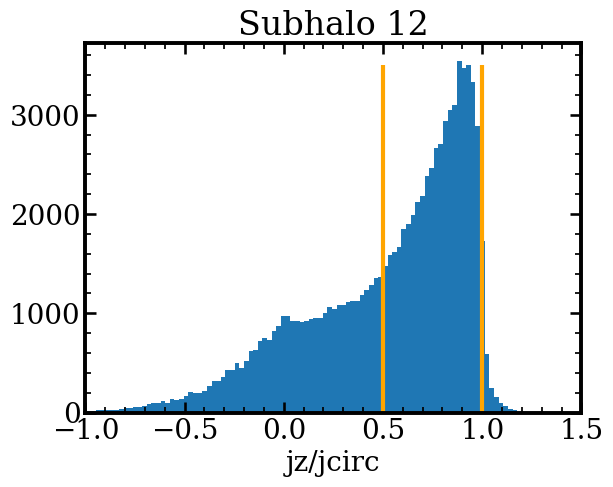

In [14]:
plt.hist(ratio_masked,bins=500)
plt.vlines([0.5,1],0,3500,color='orange',lw=3)
plt.xlim(-1,1.5)
plt.xlabel('jz/jcirc')

plt.title(f'Subhalo {subhalo_id}')

Visually, it looks like there are two approximately gaussian components to this distribution: one centered at 0, and another that sharply peaks near 1. One could apply a more sophisticated fit to these underlying distributions and carefully distinguish between the two, but as previously mentioned we simply separate the two according to stars that have a ratio of $j_z/j_{circ}$ greater than or less than 0.5.

We now plot the distribution of the stars that we've separated into each component:

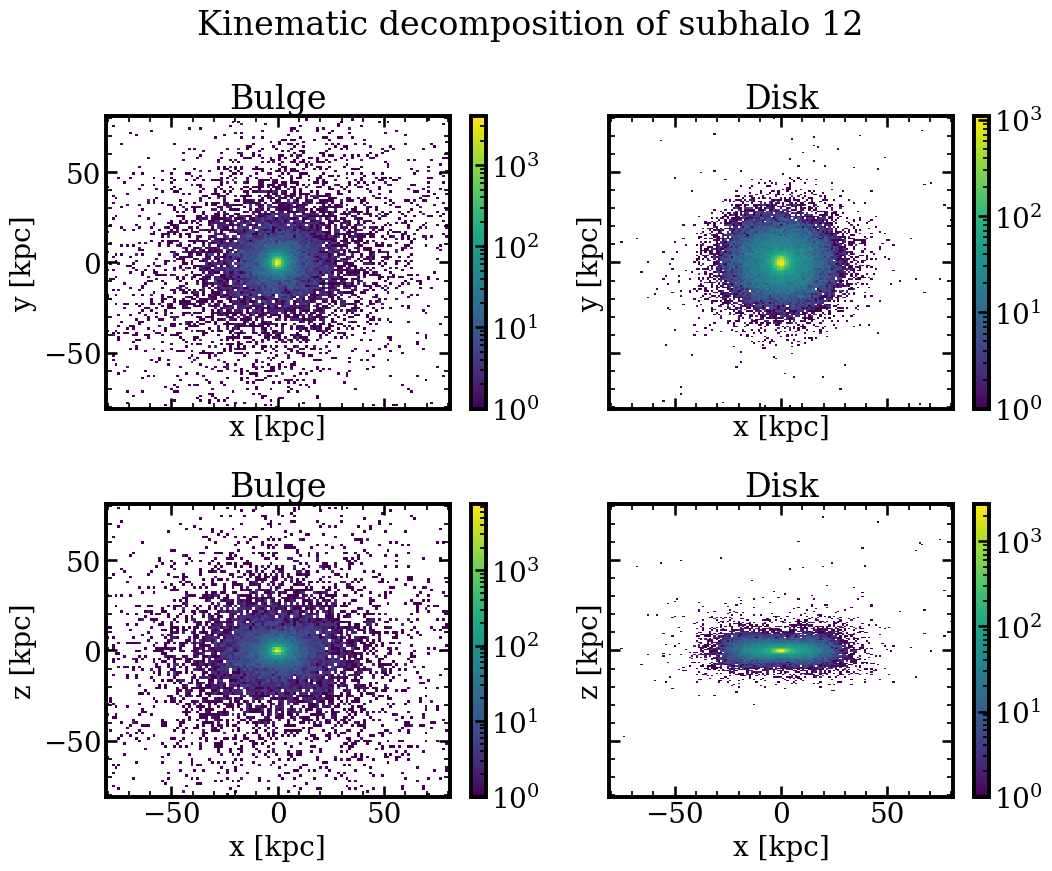

In [15]:
lim = 2*HMR

fig,axs=plt.subplots(2,2,figsize = (11,9),sharex=True,sharey=True)

counts1, xedges1, yedges1, im1 = axs[0,0].hist2d(Bulge[:,0],Bulge[:,1],norm='log',bins=300)
counts2, xedges2, yedges2, im2 = axs[0,1].hist2d(Disk[:,0],Disk[:,1],norm='log',bins=300)
axs[0,0].set_title('Bulge')
axs[0,1].set_title('Disk')
axs[0,0].set_xlabel('x [kpc]')
axs[0,1].set_xlabel('x [kpc]')
axs[0,0].set_ylabel('y [kpc]')
axs[0,1].set_ylabel('y [kpc]')

counts3, xedges3, yedges3, im3 = axs[1,0].hist2d(Bulge[:,0],Bulge[:,2],norm='log',bins=300)
counts4, xedges4, yedges4, im4 = axs[1,1].hist2d(Disk[:,0],Disk[:,2],norm='log',bins=300)

axs[1,0].set_title('Bulge')
axs[1,1].set_title('Disk')
axs[1,0].set_xlabel('x [kpc]')
axs[1,1].set_xlabel('x [kpc]')
axs[1,0].set_ylabel('z [kpc]')
axs[1,1].set_ylabel('z [kpc]')

for ax in axs.flatten():
    ax.set_xlim(-lim,lim)
    ax.set_ylim(-lim,lim)

fig.colorbar(im1, ax=axs[0,0])
fig.colorbar(im2, ax=axs[0,1])
fig.colorbar(im3, ax=axs[1,0])
fig.colorbar(im4, ax=axs[1,1])

fig.suptitle(f'Kinematic decomposition of subhalo {subhalo_id}')

fig.tight_layout()

Now plotting the velocity distributions:

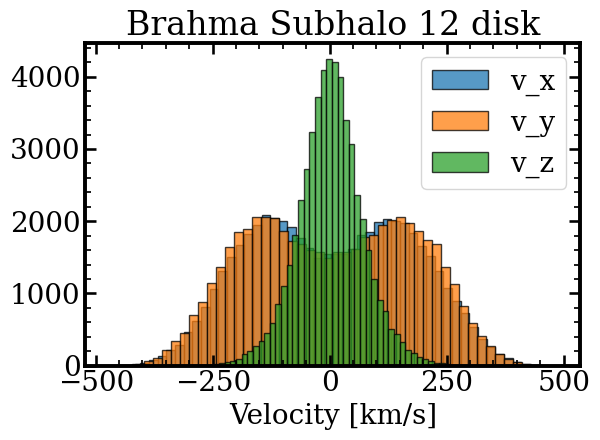

In [16]:
plt.hist(disk_vel[:,0],bins=50,edgecolor='black',label = 'v_x',alpha=0.75)
plt.hist(disk_vel[:,1],bins=50,edgecolor='black',label = 'v_y',alpha=0.75)
plt.hist(disk_vel[:,2],bins=50,edgecolor='black',label = 'v_z',alpha=0.75)

plt.legend(loc=1)
plt.title(f"Brahma Subhalo {subhalo_id} disk")
plt.xlabel("Velocity [km/s]")
plt.tight_layout()

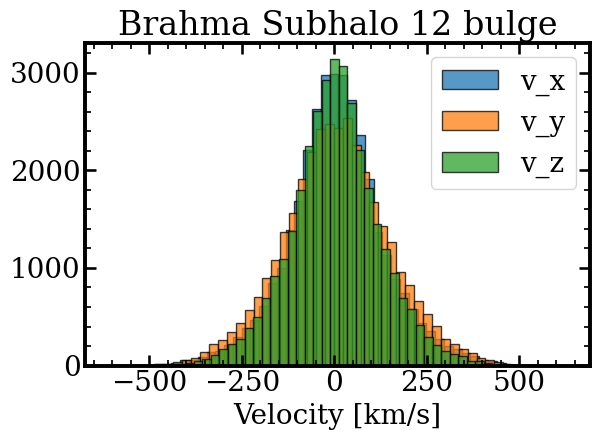

In [17]:
plt.hist(bulge_vel[:,0],bins=50,edgecolor='black',label = 'v_x',alpha=0.75)
plt.hist(bulge_vel[:,1],bins=50,edgecolor='black',label = 'v_y',alpha=0.75)
plt.hist(bulge_vel[:,2],bins=50,edgecolor='black',label = 'v_z',alpha=0.75)

plt.legend()
plt.title(f"Brahma Subhalo {subhalo_id} bulge")
plt.xlabel("Velocity [km/s]")
plt.tight_layout()